In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

In [3]:
def jaccard_coefficient(G, n1, n2):
    return list(nx.jaccard_coefficient(G, [(n1, n2)]))[0][2]

In [4]:
def add(t1, t2):
    return (t1[0] + t2[0], t1[1] + t2[1])

def sub(t1, t2):
    return (t1[0] - t2[0], t1[1] - t2[1])

In [5]:
import operator

class CircularList(list):
    def __getitem__(self, x):
        if isinstance(x, slice):
            return CircularList([self[x] for x in self._rangeify(x)])

        index = operator.index(x)
        try:
            return super().__getitem__(index % len(self))
        except ZeroDivisionError:
            raise IndexError('list index out of range')

    def _rangeify(self, slice):
        start, stop, step = slice.start, slice.stop, slice.step
        if start is None:
            start = 0
        if stop is None:
            stop = len(self)
        if step is None:
            step = 1
        return range(start, stop, step)
    
    def next(self, value):
        return self[self.index(value) + 1]
    
    def match_pattern(self, pattern: list):
        if len(pattern) == 0:
            return True
        
        current = pattern[0]
        idx = self.index(current)
        
        for i in range(len(pattern)):
            if not comp(pattern[i], current):
                return False
            current = self.next(current)
            
        return True

In [6]:
a1, a2, a3 = (1, 2), (4, 5), (6, 7)
a0 = (3, 9)

A = CircularList(CircularList([a1, a2, a3]))
print(A.match_pattern([a2, a3]))
print(A.match_pattern([a3, a1]))
print(A.match_pattern([a2, a1]))
print(A.match_pattern([a2, a0]))
print(A.match_pattern([a3, a0]))

NameError: name 'comp' is not defined

In [7]:
N = nx.MultiGraph()
b = N.add_edge(1, 2, w=1)
a = N.add_edge(1, 2, w=2)
a, b

(1, 0)

In [8]:
flatten = lambda t: [item for sublist in t for item in sublist]

def cycle_from_pairs(ls_pairs):  # shall be called ingb_from_pairs
    cycle = CircularList()
    G = nx.Graph()
    for e in ls_pairs:
        G.add_edge(*e)
    old = list(G.nodes)[0]
    n = list(G.neighbors(old))[0]
    while not G.nodes[n].get("done", False):
        G.nodes[n]["done"] = True
        cycle.append(n)
        next_ = set(G.neighbors(n)).difference({old})
        if len(next_) != 1:
            raise ValueError("ls_pairs is not correct " + str(ls_pairs))
        next_ = list(next_)[0]
        old, n = n, next_
        
    return cycle

def cycle_two_pairs(ls_p):
    ls = list(map(list, ls_p))
    if ls[0][0] == ls[1][0]:
        ls[0][0], ls[0][1] = ls[0][1], ls[0][0]
    
    return list(map(tuple, ls))

def cycle_from_ordered_list_pairs(ls_p):
    """
    The case where len(ls_p) == 2 is not handled
    How to know which one is the first ?
    Let's say it doesn't matter
    """
    if len(ls_p) == 2:
        return cycle_two_pairs(ls_p)
    
    ls = list(map(list, ls_p))
    if ls[0][0] in ls[1][:2]:
        ls[0][0], ls[0][1] = ls[0][1], ls[0][0]
        
    for i in range(1, len(ls)):
        if ls[i][1] in ls[i - 1]:
            ls[i][0], ls[i][1] = ls[i][1], ls[i][0]
            
    return list(map(tuple, ls))

def list_from_cycle_dual(dict_):
    ls = flatten(list(dict_.values()))
    return list(set(ls))  # for unique

In [364]:
cycle_from_ordered_list_pairs([(0, 1), (1, 2), (0, 3), (12, 2), (3, 6), (6, 7), (7, 8), (8, 12)])

[(0, 1), (1, 2), (0, 3), (12, 2), (3, 6), (6, 7), (7, 8), (8, 12)]

In [387]:
cycle_from_ordered_list_pairs([(7, 22), (22, 23), (16, 8), (16, 23), (7, 8)])

[(7, 22), (22, 23), (16, 8), (16, 23), (7, 8)]

In [365]:
cycle_from_pairs([(0, 1), (1, 2), (0, 3), (12, 2), (3, 6), (6, 7), (7, 8), (8, 12)])

[1, 2, 12, 8, 7, 6, 3, 0]

In [369]:
cycle_from_ordered_list_pairs([[2, 1], [2, 4], [1, 4, 3]])

[(1, 2), (2, 4), (4, 1, 3)]

In [370]:
cycle_from_ordered_list_pairs([(3, -1, 0), (3, -1, 1)])

[(-1, 3, 0), (3, -1, 1)]

In [33]:
type(CircularList([1, 2, 3]) + [4])

list

In [34]:
a = CircularList([1, 2, 3])
print(type(a))
a.append(7)
print(type(a))

<class '__main__.CircularList'>
<class '__main__.CircularList'>


In [9]:
def index_of(x, ls):
    if type(x) != tuple:
        return ls.index(x)
    
    for i in range(len(ls)):
        if comp(x, ls[i]):
            return i
    raise ValueError(f"{x} is not found in {ls}")

In [10]:
def comp(a: tuple, b: tuple) -> bool:
    if a == b:
        return True
    if a[0] == b[1] and a[1] == b[0] and a[2:] == b[2:]:
        return True
    return False

def unique(ls):
    return list(set(ls))

In [13]:
class Ltuple(tuple):
    """
    ltuple implements a loose tuple class
    where index 0 and 1 are invertible
    """
    def __eq__(self, other):
        return comp(tuple(self), tuple(other))
    
    def __hash__(self):
        if self[0] < self[1]:
            return hash(tuple(self))
        
        x = list(self)
        x[0], x[1] = x[1], x[0]
        return hash(tuple(x))

In [14]:
a = Ltuple((1, 2, 3))
b = Ltuple((2, 1, 3))
a, b, a == b, b == a

((1, 2, 3), (2, 1, 3), True, True)

In [441]:
hash(a), hash(b)

(529344067295497451, 529344067295497451)

In [17]:
class GrowingPlanarNetwork:
    """
    WARN : cycle cannot be well handled when there is only 2 neighbours
    """
    """
    Rules:
    -1 A cell has at least 2 neighbours
    -2 Two connected cells have at maximum 1 common neighbour (not applied yet)
    """
    def __init__(self):
        self.G = nx.Graph()  # planar graph
        self.D = nx.MultiGraph()  # dual graph
        self.ctrl = True
        self.verbose = False
        
    def copy(self):
        gpn = GrowingPlanarNetwork()
        gpn.G = self.G.copy()
        gpn.D = self.D.copy()
        gpn.ctrl = self.ctrl
        return gpn
    
    def debug(self, d):
        if self.verbose:
            for k, v in d.items():
                print(k, ":", v)
        
    def index(self, net):
        G = self.G if net == "planar" else self.D
        return max(G.nodes) + 1
        
    def index_from_coord(self, i, j, size):
        if i < 0 or j < 0 or j >= size or i >= size:
            return None
        return i * size + j
        
    # checked for size=3
    # factorisable mais osef
    def init_square(self, size=3):
        void = -1
        G = nx.Graph()
        D = nx.MultiGraph()
        D.add_node(-1)
        D.nodes[-1]["ngb"] = CircularList()  # could be a void list
        for i in range(size):
            for j in range(size):
                pass
                    
        for i in range(size):
            for j in range(size):
                this = self.index_from_coord(i, j, size)
                less = self.index_from_coord(i - 1, j - 1, size)
                dualless = self.index_from_coord(i - 1, j - 1, size - 1)
                if i < size - 1 and j < size - 1:
                    dualthis = self.index_from_coord(i, j, size - 1)
                    D.add_node(dualthis)
                    D.nodes[dualthis]["ngb"] = CircularList()
                    
                if j > 0:
                    # horizontal planar
                    target = self.index_from_coord(i, j - 1, size)
                    dualtarget = self.index_from_coord(i, j - 1, size - 1)
                    G_edge = (this, target)
                    # horizontal dual
                    if i == 0:
                        D_edge = (void, dualtarget)
                    elif i == (size - 1):
                        D_edge = (void, dualless)
                    else:
                        D_edge = (dualtarget, dualless)
                    idx = D.add_edge(*D_edge, dual=G_edge)
                    G.add_edge(*G_edge, dual=(*D_edge, idx))
                    if D_edge[0] is not None:
                        D.nodes[D_edge[0]]["ngb"].append(Ltuple((*D_edge, idx)))
                    if D_edge[1] is not None:
                        D.nodes[D_edge[1]]["ngb"].append(Ltuple((*D_edge, idx)))
                        
                if i > 0:
                    # vertical planar
                    target = self.index_from_coord(i - 1, j, size)
                    dualtarget = self.index_from_coord(i - 1, j, size - 1)
                    G_edge = (this, target)
                    # vertical dual
                    if j == 0:
                        D_edge = (void, dualtarget)
                    elif j == (size - 1):
                        D_edge = (void, dualless)
                    else:
                        D_edge = (dualtarget, dualless)
                    
                    idx = D.add_edge(*D_edge, dual=G_edge)
                    G.add_edge(*G_edge, dual=(*D_edge, idx))
                    if D_edge[0] is not None:
                        D.nodes[D_edge[0]]["ngb"].append(Ltuple((*D_edge, idx)))
                    if D_edge[1] is not None:
                        D.nodes[D_edge[1]]["ngb"].append(Ltuple((*D_edge, idx)))
                    

        # set cyclic values for all nodes
        ngbs = [(-1, 0), (0, -1), (1, 0), (0, 1)]
        for i in range(size):
            for j in range(size):
                this = self.index_from_coord(i, j, size)
                # planar
                G.nodes[this]["ngb"] = CircularList()
                for ngb in ngbs:
                    # TODO get edge instead of node
                    new = self.index_from_coord(*add((i, j), ngb), size)
                    if new is not None:
                        G.nodes[this]["ngb"].append(new)
        
        self.G = G
        self.D = D
        
                
    def show(self, k=5, iterations=1000, dual=False):
        G = self.D if dual else self.G
        pos = nx.spring_layout(G, k=k, iterations=iterations)
        nx.draw_networkx(G, pos, node_color="orange")
        # nx.draw_networkx(G, pos, nodelist=self.get_non_border_nodes(), node_color="lightblue")
        nx.draw_networkx_labels(G, pos)
        """
        To show both planar and dual on the same plot,
        we should compute
        """
                    
    def show_all(self, k=5, iterations=1000):
        pos = nx.spring_layout(self.G, k=k, iterations=iterations)
        nx.draw_networkx(self.G, pos, node_color="orange")
        
        dual_pos = dict()
        for dn in self.D.nodes:
            if dn == -1:
                continue
            ngb = self.get_intermediate_neighbours(dn, net="dual")
            arr = np.array([pos[x] for x in ngb])
            dual_pos[dn] = arr.mean(0)
            
        nodes = list(dual_pos.keys())
        nx.draw_networkx(self.D, dual_pos, nodelist=nodes,
                         edgelist=[e for e in self.D.edges if -1 not in e],
                         labels={n: n for n in nodes}, node_color="lightblue")
        
    def get_intermediate_neighbours(self, node, net="planar"):
        """
        net is either 'planar' or 'dual'
        """
        G = self.G if net == "planar" else self.D
        ls_inter = list()
        ngbs = G.nodes[node]["ngb"]
        for ngb in ngbs:
            if net == "planar":
                ls_inter += list(G.edges[(node, ngb)]["dual"][:2])
            else:
                ls_inter += list(G.edges[ngb]["dual"][:2])
            
        return unique(ls_inter)
            
    def dual_cycle_pairs(self, node):
        ngbs = self.G.nodes[node]["ngb"]
        cycle = dict()  # order is kept by ngbs
        ls_pairs = list()
        for ngb in ngbs:
            ls_pairs.append(self.G.edges[(node, ngb)]["dual"])
        ls_pairs = cycle_from_ordered_list_pairs(ls_pairs)
        self.debug(locals())
        return {ngb: pair for ngb, pair in zip(ngbs, ls_pairs)}
    
    def planar_cycle_pairs(self, node):
        ngbs = self.D.nodes[node]["ngb"]
        cycle = dict()  # order is kept by ngbs
        ls_pairs = list()
        for ngb in ngbs:
            ls_pairs.append(self.D.edges[ngb]["dual"])
        ls_pairs = cycle_from_ordered_list_pairs(ls_pairs)
        return {ngb: pair for ngb, pair in zip(ngbs, ls_pairs)}
        
    def duplicate_random_node(self):
        n = random.choice(list(self.G.nodes))
        self.duplicate_node(n)
    
    def duplicate_node(self, node):
        """
        We have a graph, a dual graph, edge indexes and ngb cyclic order
        All must stay ok to prove consistence through recurrence
        
        Division step:
        A1) Split neighbours according to the cyclic order
        A1b) Construct "neighbour" dual node (intermediate graph with order)
        A2) Update edges and dual graph edges accordingly
        A3) Add inner edge with corresponding dual
        
        Compensation step:
        B1) Get previous neighbour dual node
        B2) Select dual node if #ngb > 4
        B3) For all of them, iteratively
        B4) Select pair of non-adjacent nodes with lowest degree
        B5) As for normal step, run a split neighbour + edge update + inner edge
        
        Make graphics to help understand
        """
        
        # A1
        ngbs = self.G.nodes[node]["ngb"]
        nb_ngbs = len(ngbs)
        half_1 = nb_ngbs // 2
        half_2 = nb_ngbs - half_1
        
        # A1b
        cycle_dual = self.dual_cycle_pairs(node)
        
        # A2 remove edge
        for ngb in ngbs:
            self.G.remove_edge(node, ngb)
        
        # division
        new_node = self.index("planar")
        self.G.add_node(new_node)
        split_ngb = random.choice(ngbs)
        current = split_ngb

        self.G.nodes[node]["ngb"] = CircularList()
        self.G.nodes[new_node]["ngb"] = CircularList()
        
        for i in range(half_1):
            self.G.add_edge(node, current, dual=cycle_dual[current])
            self.G.nodes[node]["ngb"].append(current)
            current = ngbs.next(current)
        self.G.nodes[node]["ngb"].append(new_node)
        
        opp_split_ngb = current
        for j in range(half_2):
            self.G.add_edge(new_node, current, dual=cycle_dual[current])
            self.D.edges[cycle_dual[current]]["dual"] = (new_node, current)
            self.G.nodes[new_node]["ngb"].append(current)
            ls_to_update = self.G.nodes[current]["ngb"]
            ls_to_update[ls_to_update.index(node)] = new_node
            current = ngbs.next(current)
        self.G.nodes[new_node]["ngb"].append(node)
        
            
        # A3
        first_dual_edge = Ltuple(cycle_dual[split_ngb])
        second_dual_edge = Ltuple(cycle_dual[opp_split_ngb])

        if len(cycle_dual) >= 3:
            # implicit
            first_dual, second_dual = first_dual_edge[0], second_dual_edge[0]
            
        elif len(cycle_dual) == 2:
            assert min(first_dual_edge[:2]) == min(second_dual_edge[:2])
            assert max(first_dual_edge[:2]) == max(second_dual_edge[:2])
            # need to use the non -1 dual as an anchor
            first_dual, second_dual = min(first_dual_edge[:2]), max(first_dual_edge[:2])
            ref_order = self.D.nodes[first_dual]["ngb"]
            if ref_order.match_pattern([first_dual_edge, second_dual_edge]):
                pass
            
            elif ref_order.match_pattern([second_dual_edge, first_dual_edge]):
                first_dual_edge, second_dual_edge = second_dual_edge, first_dual_edge
            
            else:
                raise RuntimeError("pattern matching on dual edge did not work")
        
        idx = self.D.add_edge(first_dual, second_dual, dual=(node, new_node))
        inner_dual_edge = Ltuple((first_dual, second_dual, idx))
        self.G.add_edge(node, new_node, dual=inner_dual_edge)
        
        # keep order for dual inner
        # to do so, cycle_dual has information on the dual edges
        # so we must insert it after this one
        idx_1 = index_of(first_dual_edge, self.D.nodes[first_dual]["ngb"])
        self.D.nodes[first_dual]["ngb"].insert(idx_1 + 1, inner_dual_edge)
        idx_2 = index_of(second_dual_edge, self.D.nodes[second_dual]["ngb"])
        self.D.nodes[second_dual]["ngb"].insert(idx_2 + 1, inner_dual_edge)
        
        # B
        dual_list = list_from_cycle_dual(cycle_dual)
        self.debug(locals())
        
        for dual_node in dual_list:
            if self.D.degree(dual_node) > 4 and dual_node != -1:
                self.shorten_cycle(dual_node)
        
    def shorten_cycle(self, dual_node):  # aka Compensation Step
        """
        This function adds an edge between two opposite nodes in a cycle
        if the cycle is longer than 5, because it is not biologically plausible
        
        Compensation step:
        B1) Get previous neighbour dual node
        B2) Select dual node if #ngb > 4
        B3) For all of them, iteratively
        B4) Select pair of non-adjacent nodes with lowest degree
        B5) As for normal step, run a split neighbour + edge update + inner edge
        """
        rand_planar_ngb = self.get_intermediate_neighbours(dual_node, net="dual")
        random.shuffle(rand_planar_ngb)
        min_pair = None
        min_score = 1e6
        # B4
        for i in rand_planar_ngb:
            for j in rand_planar_ngb:
                if j <= i or (i, j) in self.G.edges:
                    continue
                score = self.G.degree(i) + self.G.degree(j)
                if score < min_score:
                    min_pair = (i, j)
                    min_score = score
                    
        # B5
        if self.verbose:
            print("Shorten", min_pair, "on", dual_node)
        
        # A1
        ngb_edges = self.D.nodes[dual_node]["ngb"]
        nb_ngbs = len(ngb_edges)
        
        
        # A1b
        map_edge_pair = self.planar_cycle_pairs(dual_node)
        
        ordered_cycle_pairs = cycle_from_ordered_list_pairs([map_edge_pair[x] for x in ngb_edges])
        
        ingbs = CircularList([x[0] for x in ordered_cycle_pairs])
        
        map_ingb_pair = {x[0]: x for x in ordered_cycle_pairs}
        
        # A2 remove edge
        for edge in ngb_edges:
            try:
                self.D.remove_edge(*edge)
            except:
                self.debug(locals())
                raise
        
        # division
        new_node = self.index("dual")
        self.D.add_node(new_node)
        
        split_ngb_1, split_ngb_2 = min_pair
        current = split_ngb_1

        self.D.nodes[dual_node]["ngb"] = CircularList()
        self.D.nodes[new_node]["ngb"] = CircularList()
        
        self.debug(locals())
        
        while current != split_ngb_2:
            planar_edge = map_ingb_pair[current]
            dual_edge = self.dual(planar_edge)
            
            self.D.add_edge(*dual_edge, dual=planar_edge)
            self.D.nodes[dual_node]["ngb"].append(dual_edge)
            
            current = ingbs.next(current)
        
        
        while current != split_ngb_1:
            planar_edge = map_ingb_pair[current]
            dual_edge = self.dual(planar_edge)
            
            current_edge = self.replace_node(dual_edge, dual_node, new_node)[:2]
            
            idx = self.D.add_edge(*current_edge, dual=planar_edge)
            new_edge = (*current_edge, idx)
            
            self.G.edges[planar_edge]["dual"] = new_edge
            self.D.nodes[new_node]["ngb"].append(new_edge)
            
            dual_current = self.get_other_node(dual_edge, dual_node)
            ls_to_update = self.D.nodes[dual_current]["ngb"]
            
            ls_to_update[index_of(dual_edge, ls_to_update)] = new_edge
            
            current = ingbs.next(current)
        
        
        idx = self.D.add_edge(dual_node, new_node)
        inner_dual_edge = Ltuple((dual_node, new_node, idx))
        self.D.nodes[dual_node]["ngb"].append(inner_dual_edge)
        self.D.nodes[new_node]["ngb"].append(inner_dual_edge)
        
        self.G.add_edge(split_ngb_1, split_ngb_2, dual=inner_dual_edge)
        self.D.edges[inner_dual_edge]["dual"] = (split_ngb_1, split_ngb_2)
        
        
        idx_1 = index_of(map_ingb_pair[split_ngb_1][1], self.G.nodes[split_ngb_1]["ngb"])
        self.G.nodes[split_ngb_1]["ngb"].insert(idx_1 + 1, split_ngb_2)
        idx_2 = index_of(map_ingb_pair[split_ngb_2][1], self.G.nodes[split_ngb_2]["ngb"])
        self.G.nodes[split_ngb_2]["ngb"].insert(idx_2 + 1, split_ngb_1)
        
        return new_node

        
    def replace_node(self, edge, old, new):
        edge_ = list(edge)
        edge_[edge_.index(old)] = new
        return tuple(edge_)
    
    def swap_node(self, node1, node2):
        pass
    
    def print_edges(self, dual=False):
        G = self.D if dual else self.G
        for e in G.edges:
            print(e, G.edges[e])
            
    def print_nodes(self, dual=False):
        G = self.D if dual else self.G
        for n in G.nodes:
            print(n, G.nodes[n])
        
    def debug_all(self):
        plt.figure()
        self.show(dual=False)
        plt.figure()
        self.show(dual=True)
        self.print_edges(dual=False)
        self.print_nodes(dual=False)
        self.print_edges(dual=True)
        self.print_nodes(dual=True)
        
    # helpers (to use at the end to simplify the code)
    def dual(self, edge):
        if len(edge) == 2:
            return self.G.edges[edge]["dual"]
        
        elif len(edge) == 3:
            return self.D.edges[edge]["dual"]
        
        else:
            raise ValueError(f"edge not recognised : {edge}")
            
    def get_other_node(self, edge, node):
        if edge[0] == node:
            return edge[1]
        
        elif edge[1] == node:
            return edge[0]
        
        else:
            raise ValueError(f"{node} is not in {edge}")
            
    def check_dual_ngb_consistency(self, node):
        if node not in self.D.nodes:
            return
        ngb_edges = self.D.nodes[node]["ngb"]
        nb_ngbs = len(ngb_edges)
        map_edge_pair = self.planar_cycle_pairs(node)
        ordered_cycle_pairs = cycle_from_ordered_list_pairs([map_edge_pair[x] for x in ngb_edges])
        
        for i in range(1, len(ordered_cycle_pairs)):
            assert ordered_cycle_pairs[i][0] == ordered_cycle_pairs[i - 1][1]
            
    def create_edge(self, source, target):
        """
        Only for planar graph, not for dual
        """
        pass
        
    def remove_node(self, node):
        """
        In a remove node, we first connect all neighbours that are not
        A) for all ngb pairs, add edge if not exists
        B) effectively remove the central node
        C) shorten the central cycle
        """
        
        # A
        # A1
        ngbs = self.G.nodes[node]["ngb"]
        nb_ngbs = len(ngbs)
        
        # A1b
        cycle_dual = self.dual_cycle_pairs(node)
        print(cycle_dual, ngbs)
        
        for i in range(nb_ngbs):
            n_a, n_b = ngbs[i], ngbs[(i + 1) % nb_ngbs]
            
            self.create_edge(n_a, n_b)

In [18]:
random.seed(0)
GPN = GrowingPlanarNetwork()
GPN.init_square()
GPN.remove_node(4)

{1: (1, 0, 0), 3: (0, 2, 0), 7: (2, 3, 0), 5: (3, 1, 0)} [1, 3, 7, 5]


In [528]:
random.seed(0)
GPN = GrowingPlanarNetwork()
GPN.init_square()
# GPN.show_all()
# GPN.duplicate_random_node()
GPN.duplicate_node(4)
# plt.figure()
# GPN.show_all()
for i in range(400):
    print(i, end="")
    GPN.duplicate_random_node()
    GPN.check_dual_ngb_consistency(77)
    
# plt.figure(figsize=(10, 10))
# GPN.show_all()
# GPN.check_dual_ngb_consistency(77)
# GPN.verbose = True
# GPN.duplicate_random_node()

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199200201202203204205206207208209210211212213214215216217218219220221222223224225226227228229230231232233234235236237238239240241242243244245246247248249250251252253254255256257258259260261262263264265266267268269270271272273274275276277278279280281282283284285286287288289290291292293294295296297298299300301302303304305306307308309310311312313314315316317318319320321322323324325326327328329330331332333334335336337338339340341342343344345346347348349350351352353354355356357358359360361362363364365366367368369

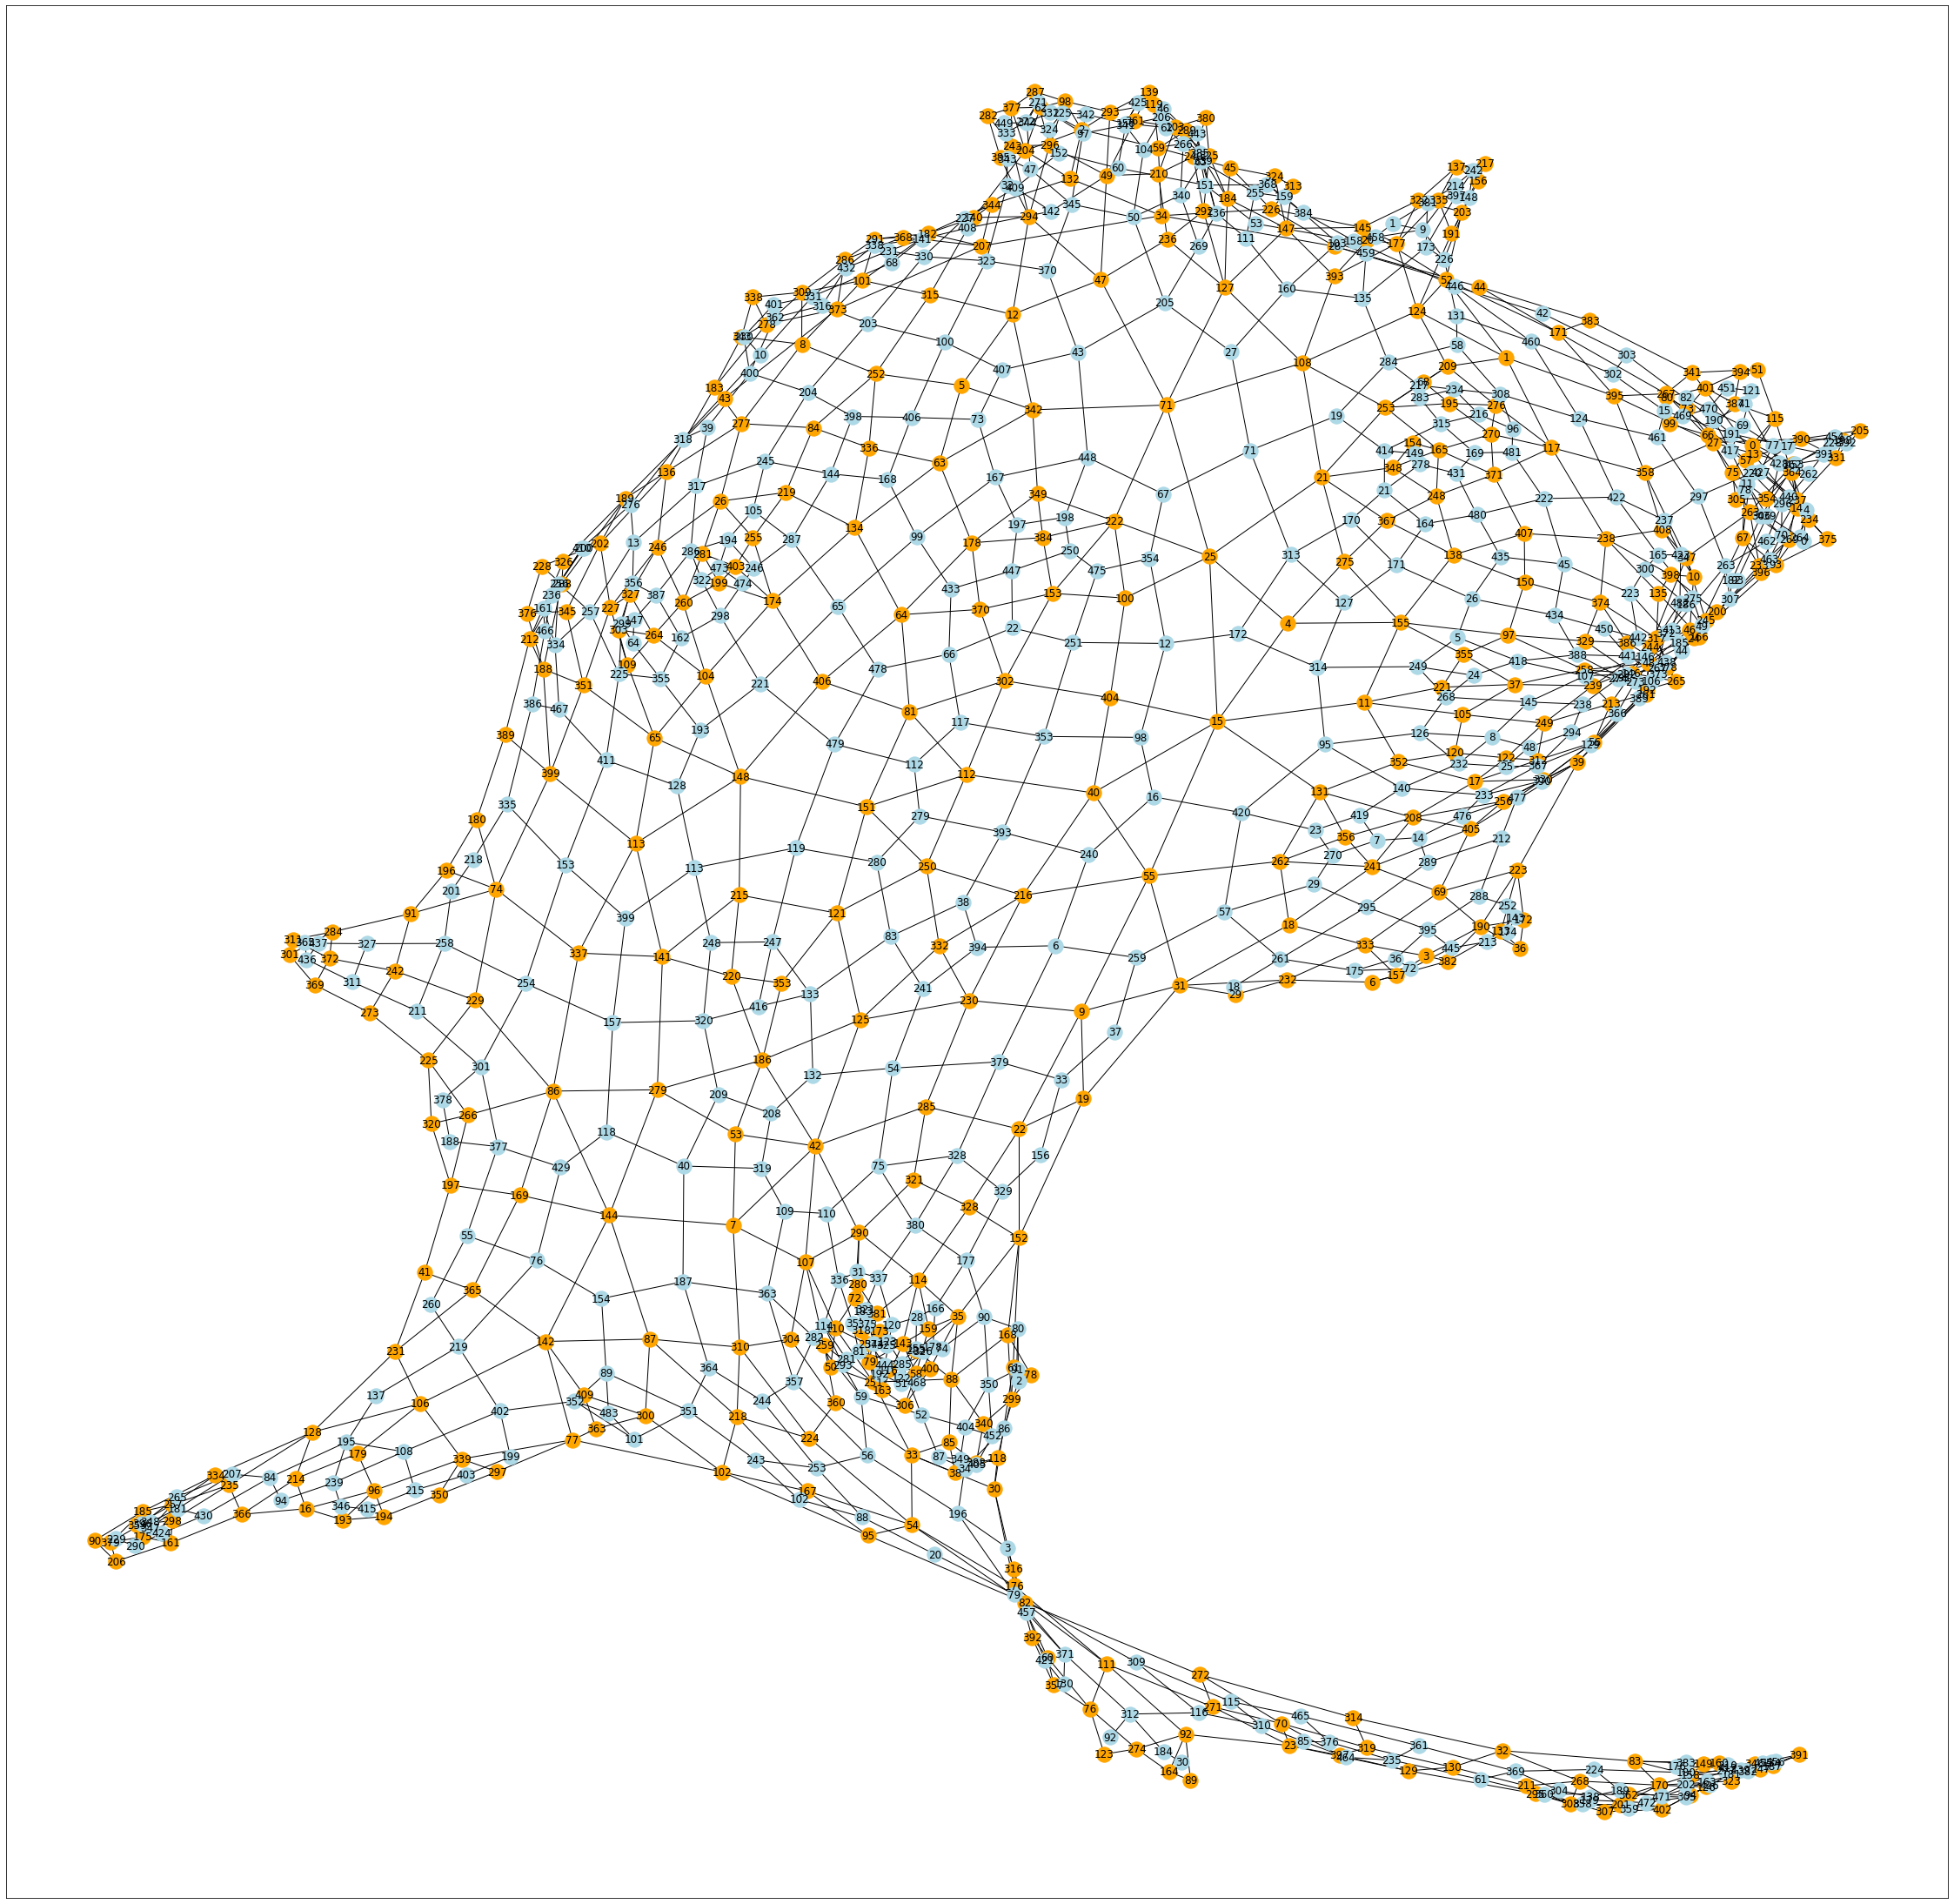

In [545]:
plt.figure(figsize=(40, 40))
GPN.show_all(k=0.2, iterations=500)

In [498]:
list(GPN.G.neighbors(14)), GPN.G.nodes[14], GPN.G.nodes[13]

([13, 24, 75, 0], {'ngb': [13, 0, 75, 24]}, {'ngb': [67, 44, 51, 14]})

Notes

Considering that our developmental model is ok (I think that heterogeneity in division location can lead to something quite unexpected, we'll see.

However, the next step is to build simple equation.

In [252]:
def test_square():
    GPN = GrowingPlanarNetwork()
    GPN.init_square()
    # test edge planar graph
    
    # test edge dual graph
    
    # test cyclic order planar
    
    # test cyclic order dual
    
    # test intermediate